# Compositional Cyber-Physical Systems Theory: Algebraic UAV

Author: Georgios Bakirtzis bakirtzis.net (bakirtzis@virginia.edu)

In [1]:
# Libraries
using AlgebraicDynamics
using AlgebraicDynamics.DWDDynam
using Catlab.WiringDiagrams
using Catlab.Graphics
using Catlab.Graphics.Graphviz
using Plots
using Plots.PlotMeasures
using DifferentialEquations
#---
using LabelledArrays

In [2]:
show_diagram(d::WiringDiagram) = to_graphviz(d,
  orientation=LeftToRight,
  labels=true, label_attr=:xlabel,
  node_attrs=Graphviz.Attributes(
    :fontname => "Helvetica",
  ),
  edge_attrs=Graphviz.Attributes(
    :fontname => "Helvetica",
  )
)

show_diagram (generic function with 1 method)

## Individual UAV
This wiring diagram is determines the behavior of a single UAV. It dictates the motion of the UAV and the control inputs needed to alter its state.

In [3]:
s = Box(:sensor, [:s, :e], [:s′])
c = Box(:controller, [:d, :s′], [:c])
d = Box(:dynamics, [:c], [:s])

Box(:dynamics, [:c], [:s])

In [4]:
# Diagram:           Inputs, Outputs <- Ports of entire diagram
UAV = WiringDiagram([:e,:d], [:s])

# Associate boxes to diagram
sensor     = add_box!(UAV, s)
controller = add_box!(UAV, c)
dynamics   = add_box!(UAV, d)

add_wires!(UAV, [
    # net inputs
    (input_id(UAV), 1) => (sensor, 2),
    (input_id(UAV), 2) => (controller, 2),

    # connections
    (sensor, 1) => (controller, 1),
    (controller, 1) => (dynamics, 1),
    (dynamics, 1) => (sensor, 1),

    # net output
    (dynamics, 1) => (output_id(UAV), 1) ])

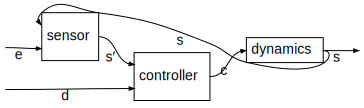

In [5]:
show_diagram(UAV)

![Cat](https://ctms.engin.umich.edu/CTMS/Content/AircraftPitch/System/Modeling/figures/flightdynamics.png)

To provide collision avoidance the controller must steer the UAV acordingly. Whenever the vehicle encounters an obstable it will ignore it's other commands and steer way from the obstacle. Once it has moved passed the obstacle the other commands are enabled and the collision avoidance is dissabled. 

In [6]:
# Motion restrictions. 
"""
αmax = deg2rad(15)                # Stall angle of attack
𝛿max = αmax/1.35635               # Maximum deflection before stall
dθmax = 0.0025036 * αmax * 56.7   # maximum steady-state angular velocity
dmin = (2*R/dθmax + R^2)^0.5      # Minimum collision distance
dmin = dmin*(1 + αmax/2)          # approximate correction due to reponse lag, small A.o.A.
""";

In [7]:
# NOTE: need different collision avoidance algorithm for moving targets.

# Global variable to avoid wires
state = Array{Any}(undef, 2)
for i in 1:2
    state[i] = @LArray zeros(4) (:α, :θ, :x, :y) 
end

function semantics(diagram::WiringDiagram; box::Int, tgt::Any)                    

    # Obstacle avoidance control
    function avoidance(u, x, p)        
        # velocity vector
        γ = u.θ - u.α  # Can approximate flight path with pitch angle
        cosγ = cos(γ) 
        sinγ = sin(γ)
        
        # projected distances
        if tgt == :static
            dx = p.x - u.x
            dy = p.y - u.y
        else
            dx = state[tgt].x - u.x
            dy = state[tgt].y - u.y
        end
        
        yᴸ = cosγ*dy - sinγ*dx
        xᴸ = cosγ*dx + sinγ*dy
        r = sqrt(dx^2 + dy^2)
        
        # error
        ϵ = (p.R - abs(yᴸ))/r * (yᴸ > 0 ? -1 : 1) # error is proportional to radial distance
        
        # gains
        Kγ = y
        Ky = (abs(yᴸ) < p.R ? 1 : 0)                    # disable correction for no collision 
        Kx = (r < p.dmax && xᴸ > 0 || r < p.R) ? 1 : 0  # enable correction if within range or inside circle
        
        # control output
        return ϵ*(Ky*Kx) + x*(1 - Kx)
    end

    #---------- State equations:
    
    function equation_sensor(u, x, p, t)
        p = p[box]            # Access parameters of given box
        u = @LArray u (:sl,)
        x = @LArray x (:θ, :e) 
        return LVector( dsl = -p.λs*(u.sl - x.θ - x.e) ) 
    end

    function equation_control(u, x, p, t)
        p = p[box]   
        u = @LArray [u; state[box]] (:sc, :α, :θ, :x, :y) # append extra data
        x = @LArray x (:sl, :d)  
        
        xᵗ = x.d - p.Kθ*x.sl             # Net input
        xᵗ = avoidance(u, xᵗ, p)         # apply obstacle avoidance
        xᵗ = clamp(xᵗ, -p.𝛿max, p.𝛿max)   # restrict deflection
        
        return LVector( dsc = -p.λc*(u.sc - xᵗ) )
    end 
    
    function equation_dynamic(u, x, p, t)
        p = p[box]
        u = @LArray u (:α, :q, :θ, :x, :y)
        x = @LArray x (:sc,)
        γ = u.θ - u.α
        
        global state[box] = LVector(α=u.α, θ=u.θ, x=u.x, y=u.y) # Store state
        
        return LVector( 
            dα = -0.313*u.α + 56.7*u.q + 0.232*x.sc,
            dq = -0.0139*u.α - 0.426*u.q + 0.0203*x.sc,
            dθ = 56.7*u.q,
            dx = cos(γ),
            dy = sin(γ) )
    end
    
    # Readout functions:  [select specific state]
    readout_sensor(u)  = [ u[1] ];  # sl
    readout_control(u) = [ u[1] ];  # sc
    readout_dynamic(u) = [ u[3] ];  # θ
    
    # Machines for each box in diagram:
                                  # Inputs, States, Outputs
    s_machine = ContinuousMachine{Float64}( 2, 1, 1, equation_sensor , readout_sensor );
    c_machine = ContinuousMachine{Float64}( 2, 1, 1, equation_control, readout_control ); 
    d_machine = ContinuousMachine{Float64}( 1, 5, 1, equation_dynamic, readout_dynamic ); 
    
    # Output composition
    return oapply( diagram, [s_machine, c_machine, d_machine] );
end

semantics (generic function with 1 method)

In [8]:
# Coordinates of a cicle - used for plotting
function circleShape(x, y, r)
    θ = collect( 0 : pi/100 : 2*pi )
    return cos.(θ)*r .+ x, sin.(θ)*r .+ y
end; 

## 1. Static obstacle - 1 UAV
Consider a case where a UAV is flying into a static obstacle. To avoid it must mometarily change it's trajectory to avoid hitting the object. 

In [9]:
comp_1 = semantics(UAV, box=1, tgt=:static)

ContinuousMachine(ℝ^7 × ℝ^2 → ℝ^7)

In [10]:
param_1 = LVector(
        λs=100,      # Response frequency of sensor
        λc=100,      # Response frequecy of controller
        Kθ=1,        # Gain of control input proportional to sensor output. Causes a feedback loop.
        x=100,       # target x
        y=1,         # target y
        R=20,        # Target radius
        dmax=50,     # Distance at which collision avoidance starts
        𝛿max=0.193 );# Maximum deflection 

In [11]:
# Initial values
x_init = LVector(e1=0.0, d1=0)
u_init = LVector(sl1=0.0, sc1=0.0, α1=0.0, q1=0.0, θ1=0.0, x1=0.0, y1=0.0)

# Integration interval
t_span = (0.0, 200.0); 

# Solve system
sol = solve( ODEProblem(comp_1, u_init, x_init, t_span, [param_1]), alg_hints=[:stiff] );

┌ Info: Saved animation to 
│   fn = /home/raul_catlab/Desktop/composition_notebook/algebraic_uav/static_obstacle.gif
└ @ Plots /home/raul_catlab/.julia/packages/Plots/CoJwR/src/animation.jl:104


Plots.AnimatedGif("/home/raul_catlab/Desktop/composition_notebook/algebraic_uav/static_obstacle.gif")
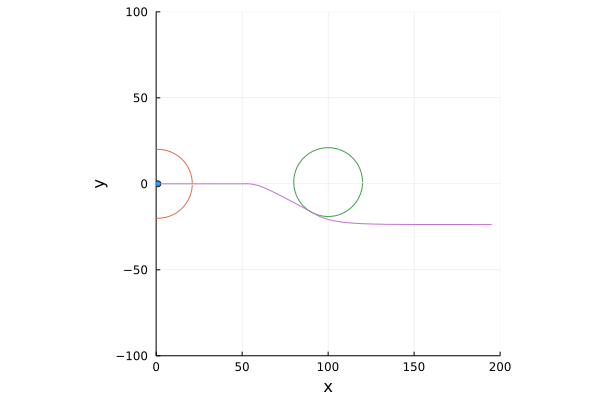

In [12]:
anim = @animate for i = 1:t_span[end]
    # coordinates
    x = [ sol(i)[6] ]
    y = [ sol(i)[7] ]
    
    plot( legend=false, aspect_ratio=:equal, xlims=(0,200), ylims=(-100,100), xlabel="x", ylabel="y" )
    
    # aircraft
    scatter!(x, y)
    plot!( circleShape(x, y, param_1.R) )
    
    # target
    plot!( circleShape(param_1.x, param_1.y, param_1.R))
    
    # trajectory
    plot!( sol[6,:], sol[7,:] )
end
 
gif(anim, "static_obstacle.gif", fps = 30)

## 2. Moving obstacle - 2 UAV's

A more complicated example involves two UAV's are flying simultaneously and attempt to avoid each other. It is nessesary to compose both UAV's to make a larger system. The solution to the resulting system indicates whether the collision avoidance was succesful or not. Generally the corrections required for moving bodies tend to differ to those of static bodies.

In [13]:
comp_1 = semantics(UAV, box=1, tgt=2)  # This generates a continous machine that can be assigned to boxes
comp_2 = semantics(UAV, box=2, tgt=1) 

ContinuousMachine(ℝ^7 × ℝ^2 → ℝ^7)

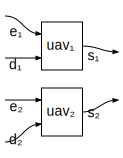

In [14]:
# Note: each box needs a set of parameters
net = WiringDiagram([:e₁, :d₁, :e₂, :d₂], [:s₁, :s₂])

uav_1 = add_box!(net, Box(:uav₁, [:e₁, :d₁], [:s₁]))
uav_2 = add_box!(net, Box(:uav₂, [:e₂, :d₂], [:s₂]))

add_wires!(net, [ 
    # UAV 1
    (input_id(net), 1) => (uav_1, 1),
    (input_id(net), 2) => (uav_1, 2),
    (uav_1, 1) => (output_id(net), 1),
        
    # UAV 2
    (input_id(net), 3) => (uav_2, 1),
    (input_id(net), 4) => (uav_2, 2),
    (uav_2, 1) => (output_id(net), 2) ])

show_diagram(net)

Each UAV is assigned a box and the resulting system is determines by their mutual behavior. This can be done through a box and wiring diagram composition. The _oapply_ function returns a continous machine that can be assigned to another diagram.

In [15]:
net_system = oapply(net, [comp_1, comp_2])

ContinuousMachine(ℝ^14 × ℝ^4 → ℝ^14)

In [16]:
# Initial values
θ = deg2rad(180 - 25)

x_init = LVector(
          e1=0.0, d1=θ,
          e2=0.0, d2=0.0)

u_init = LVector(
          sl1=0.0, sc1=0.0, α1=0.0, q1=0.0, θ1=θ,   x1=200.0, y1=-55.0, 
          sl2=0.0, sc2=0.0, α2=0.0, q2=0.0, θ2=0.0, x2=0.0,   y2=0.0)

# Integration interval
t_span = (0.0, 200.0); 

# Parameters
param_2 = deepcopy(param_1);
p_list = [param_1, param_2];

# Solve system
sol = solve( ODEProblem(net_system, u_init, x_init, t_span, p_list), alg_hints=[:stiff] );

┌ Info: Saved animation to 
│   fn = /home/raul_catlab/Desktop/composition_notebook/algebraic_uav/moving_obstacle.gif
└ @ Plots /home/raul_catlab/.julia/packages/Plots/CoJwR/src/animation.jl:104


Plots.AnimatedGif("/home/raul_catlab/Desktop/composition_notebook/algebraic_uav/moving_obstacle.gif")
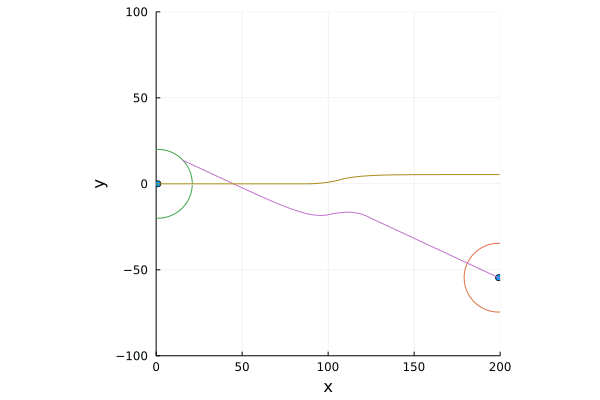

In [17]:
anim = @animate for i = 1:t_span[end]
    # coordinates
    x = [ sol(i)[6], sol(i)[13] ]
    y = [ sol(i)[7], sol(i)[14] ]
    
    plot( legend=false, aspect_ratio=:equal, xlims=(0,200), ylims=(-100,100), xlabel="x", ylabel="y" )
    
    # aircraft
    scatter!(x, y)
    plot!( circleShape(x[1], y[1], param_1.R) )
    plot!( circleShape(x[2], y[2], param_2.R) )
    
    # trajectory
    plot!( [sol[6,:], sol[13,:]], [sol[7,:],sol[14,:]] )   
end
 
gif(anim, "moving_obstacle.gif", fps = 30)